# Hands-on querying NOMAD for electronic properties of DFT and GW data of bulk Si<sub>2</sub>

There are several routes when querying data in NOMAD. You can visit the corresponding documentation page, [Using the APIs](https://nomad-lab.eu/prod/v1/staging/docs/api.html#overview) to learn more about the details.

In this notebook, we will use the `ArchiveQuery` functionality as described in [Python package > Query processed data](https://nomad-lab.eu/prod/v1/staging/docs/api.html#overview). Then, we will used the processed NOMAD archive to extract the metainformation for electronic properties in a DFT and GW calculations in bulk Si<sub>2</sub>.

In [2]:
import matplotlib.pyplot as plt
from nomad.client import ArchiveQuery

## Querying the DFT+GW data

We now query the NOMAD archive trying to find results for `Si` containing DFT and GW data. If present (as it is the case), a DFT+GW calculation for a given material would have produced three entries: a _DFT SinglePoint_, a _GW SinglePoint_, and a _GW workflow_. This last entry contains all the metainformation we are looking for.

Thus, the search will look for _GW workflow_ entries if they contain both `GW.type` as well as `GW.starting_point_type`. We will also query data that contains information about the `dos_electronic`.

In order to find data using `ArchiveQuery`, we need to define (among other optional arguments):

1. The _base_url_ of NOMAD with the version from which we want to query the data. 
2. A dictionary with the _query_ as obtained from the `<>` button in the NOMAD Explore GUI.
3. A dictionary with the _required_ sections to be resolved from the queried entries.

For point 1.,  we will be querying data from the [Beta version]((https://nomad-lab.eu/prod/v1/staging/api/v1)). Points 2. and 3. are defined below.

In [3]:
base_url = 'https://nomad-lab.eu/prod/v1/staging/api/v1'
query = {
    "results.material.elements:all": [
        "Si"
    ],
    "results.material.n_elements": {
        "gte": 1,
        "lte": 1
    },
    "results.method.simulation.gw.type:any": [
        "G0W0"
    ],
    "results.method.simulation.gw.starting_point_type:any": [
        "LDA"
    ],
    "results.properties.available_properties:all": [
        "dos_electronic"
    ]
}
required = {
    'results': 'include-resolved',
    'run': 'include-resolved'
}

We can now find all the processed NOMAD archives with these characteristics by using `ArchiveQuery` and its method `download()`.

In [4]:
archives = ArchiveQuery(url=base_url, query=query, required=required).download()
archives

Fetching remote uploads...
1 entries are qualified and added to the download list.


[EntryArchive(run, results)]

For simplicity, we will constraint ourselves to the first entry. We can nicely visualize the populated sections and quantities by using the `EntryArchive` method `m_to_json()` passing the indent as an argument.

In [5]:
archive = archives[0]
print(archive.m_to_json(indent=2))

{
  "run": [
    {
      "program": {
        "name": "exciting",
        "version": "CARBON"
      },
      "system": [
        {
          "type": "bulk",
          "configuration_raw_gid": "p0QhpuszgKRJiMDsTza3yMdst5Ji",
          "is_representative": true,
          "chemical_composition": "SiSi",
          "chemical_composition_hill": "Si2",
          "chemical_composition_reduced": "Si",
          "atoms": {
            "species": [
              14,
              14
            ],
            "labels": [
              "Si",
              "Si"
            ],
            "positions": [
              [
                0.0,
                0.0,
                0.0
              ],
              [
                1.3573395459687024e-10,
                1.3573395459687024e-10,
                1.3573395459687024e-10
              ]
            ],
            "lattice_vectors": [
              [
                2.714679091937405e-10,
                2.714679091937405e-10,
              

## Resolving the density of states (DOS)

We can now check that the DOS is present under `results.properties.electronic`.

In [6]:
print(archive.results)
print(archive.results.properties)
print(archive.results.properties.electronic)
dos = archive.results.properties.electronic.dos_electronic
print(dos)

Results(material, method, properties)
Properties(n_calculations, structures, electronic)
ElectronicProperties(band_gap, dos_electronic, band_structure_electronic)
[DOSElectronic(energies, total, label, spin_polarized, energy_fermi, band_gap), DOSElectronic(energies, total, label, spin_polarized, energy_fermi, band_gap)]


`dos` is a list of length 2, which contains 'DFT' bands for the first element, and 'GW' bands for the second element (we can check this by printing `label` within each element). The parsed data is contained in `energies` and `total[0].value`.

Besides these main DOS quantities, we also store metainformation about the `energy_fermi`, i.e., the energy reference, as well as the derived `band_gap`. If the system is a metal, i.e., `energy_fermi` is crossing a finite DOS, then the reported `band_gap` is 0.

## Plotting the DOS and comparing the band gap from DFT and GW

In NOMAD, quantities are stored in SI units (e.g., energies in Joules, temperatures in Kelvin, etc.). These quantities with units can be manipulated using two methods: `to(unit)` and `magnitude`. 

- `to(unit)`: transform the units to the prefered string `unit`.
- `magnitude`: transform the quantity into its magnitude without units.

Knowing this, we can finally visualize the DOS from DFT and GW.

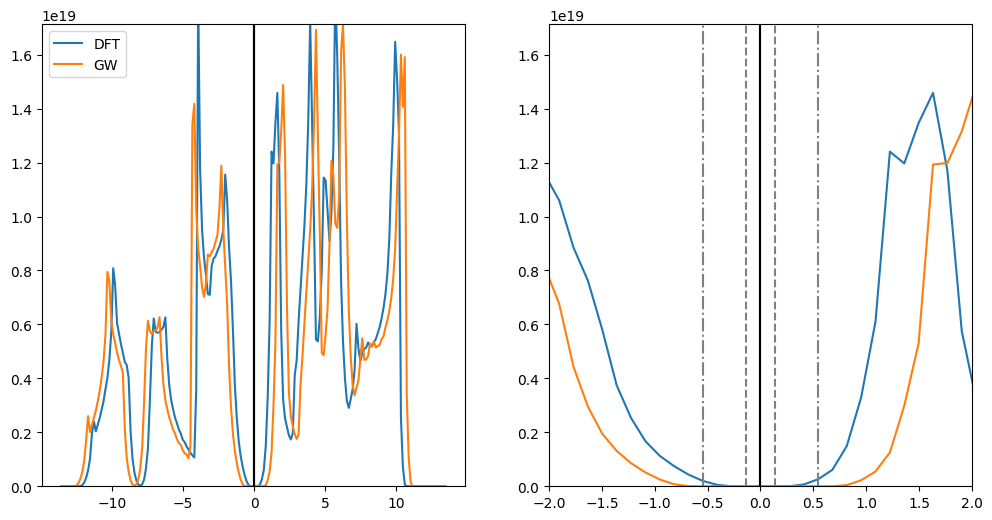

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for d in dos:
    # We store label for each methodology ('DFT', 'GW')
    label = d.label
    energies = (d.energies - d.energy_fermi).to('eV').magnitude
    value = d.total[0].value.magnitude
    ax.plot(energies, value, label=label)
    ax.legend()
    ax.set_ylim([0, max(value)])
    ax.axvline(x=0, ymin=0, ymax=max(value), c='k')
    ax2.plot(energies, value)
    ax2.set_xlim([-2, 2])
    ax2.set_ylim([0, max(value)])
    ax2.axvline(x=0, ymin=0, ymax=max(value), c='k')
    homo = (d.band_gap[0].energy_highest_occupied - d.energy_fermi).to('eV').magnitude
    lumo = (d.band_gap[0].energy_lowest_unoccupied - d.energy_fermi).to('eV').magnitude
    if label == 'DFT':
        ax2.axvline(x=homo, ymin=0, ymax=max(value), c='gray', linestyle='--')
        ax2.axvline(x=lumo, ymin=0, ymax=max(value), c='gray', linestyle='--')
    else:
        ax2.axvline(x=homo, ymin=0, ymax=max(value), c='gray', linestyle='-.')
        ax2.axvline(x=lumo, ymin=0, ymax=max(value), c='gray', linestyle='-.')

We can also obtain the band gap derived from the highest and lowest occupied states around the Fermi level.

In [8]:
bandgap_dft = dos[0].band_gap[0].value.to('eV')
bandgap_gw = dos[1].band_gap[0].value.to('eV')
print(f'The DFT band gap is = {bandgap_dft}\n')
print(f'The GW band gap is = {bandgap_gw}')

The DFT band gap is = 0.2721138624598849 electron_volt

The GW band gap is = 1.088455449839539 electron_volt
